In [1]:
!pip install ipywidgets
!pip install torchviz

Experiment # 2
===============

Generative transformer backbone (pretrained with tagalog websites) + classifier head

In [2]:
import argparse
import json
import math
import random
import sys
import os
import shutil
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Sequence, Tuple

import pandas as pd
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    PreTrainedTokenizerBase,
    PreTrainedTokenizerFast,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
)
import transformers

try:
    from torch.optim.lr_scheduler import LRScheduler  # type: ignore[attr-defined]
except ImportError:  # pragma: no cover - fallback for older PyTorch versions
    from torch.optim.lr_scheduler import _LRScheduler as LRScheduler  # type: ignore

@dataclass
class TextCorpus:
    texts: List[str]
    source: str

class CharacterSequenceDataset(Dataset):
    def __init__(
        self,
        texts: Sequence[str],
        tokenizer: PreTrainedTokenizerBase,
        block_size: int,
        stride: int,
    ) -> None:
        if block_size < 2:
            raise ValueError("block_size must be at least 2")
        if stride < 1:
            raise ValueError("stride must be at least 1")

        # Suppress token length warnings as we are intentionally encoding long sequences
        verbosity = transformers.logging.get_verbosity()
        transformers.logging.set_verbosity_error()

        try:
            token_sequence: List[int] = []
            for text in texts:
                text = str(text)
                if not text.strip():
                    continue
                encoded = tokenizer.encode(text, add_special_tokens=True, truncation=False)
                if not encoded:
                    continue
                token_sequence.extend(encoded)
        finally:
            transformers.logging.set_verbosity(verbosity)

        if len(token_sequence) < block_size + 1:
            raise ValueError(
                "Not enough tokens to create sequences. Try reducing block_size or increasing the number of samples."
            )

        self.tokens = torch.tensor(token_sequence, dtype=torch.long)
        self.block_size = block_size
        self.stride = stride
        max_start = len(self.tokens) - (block_size + 1)
        if max_start < 0:
            raise ValueError("Not enough tokens to create input-target pairs for the requested block size.")
        starts = list(range(0, max_start + 1, stride))
        if not starts or starts[-1] != max_start:
            starts.append(max_start)
        self.starts = starts

    def __len__(self) -> int:
        return len(self.starts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        start = self.starts[idx]
        x = self.tokens[start : start + self.block_size]
        y = self.tokens[start + 1 : start + self.block_size + 1]
        return x, y

/home/jedld/miniconda3/envs/ai351/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda



Experiment # 2: Train a generative model and then use that model as a backbone for the hate speech classifier
-------------------

In [ ]:
SEED = 42
OUTPUT_DIR = "models/tagalog_lm"
MAX_POSITION_EMBEDDINGS = 512
EMBED_DIMENSION = 256
BLOCK_SIZE = 256
NUM_HEADS = 4

TOKENIZER_VOCAB_SIZE = 32000
MIN_FREQUENCY = 2
STRIDE = 128
VAL_RATIO = 0.1
NUM_LAYERS = 6
MAX_POSITION_EMBEDDINGS = 512
DROPOUT = 0.1
FF_MULTIPLIER = 4
BATCH_SIZE = 32
WARMUP_RATIO = 0.1
EPOCHS = 50
LEARNING_RATE = 3e-4
LR_SCHEDULER = "cosine"
WEIGHT_DECAY = 1e-2
GRADIENT_CLIPPING = 1.0
LOG_INTERVAL = 100

Step 1: Preprocess data

In [5]:
# Simple text cleaning function
def _clean_texts(texts: Iterable[str]) -> List[str]:
    return [str(text).strip() for text in texts if isinstance(text, str) and str(text).strip()]


In [6]:
def train_tokenizer_from_corpus(
    texts: Sequence[str],
    vocab_size: int,
    min_frequency: int,
    limit_alphabet: int,
    lowercase: bool,
    sample_size: int,
    seed: int,
    max_length: int,
) -> Tuple[PreTrainedTokenizerBase, int]:
    try:
        from tokenizers import Tokenizer
        from tokenizers.models import BPE
        from tokenizers.normalizers import Lowercase, NFKC, Sequence as NormalizerSequence
        from tokenizers.pre_tokenizers import ByteLevel
        from tokenizers.decoders import ByteLevel as ByteLevelDecoder
        from tokenizers.processors import TemplateProcessing
        from tokenizers.trainers import BpeTrainer
    except ImportError as exc:  # pragma: no cover - optional dependency
        raise RuntimeError(
            "The 'tokenizers' package is required to train a tokenizer from scratch. Install tokenizers>=0.13."
        ) from exc

    if not texts:
        raise ValueError("Cannot train tokenizer without any text samples.")

    population = range(len(texts))
    if sample_size > 0 and sample_size < len(texts):
        rng = random.Random(seed)
        selected_indices = sorted(rng.sample(population, sample_size))
    else:
        selected_indices = population

    def iterator() -> Iterable[str]:
        for idx in selected_indices:
            text = texts[idx]
            if text:
                yield text

    tokenizer = Tokenizer(BPE(unk_token="<unk>"))
    normalizers = [NFKC()]
    if lowercase:
        normalizers.append(Lowercase())
    tokenizer.normalizer = normalizers[0] if len(normalizers) == 1 else NormalizerSequence(normalizers)
    tokenizer.pre_tokenizer = ByteLevel(add_prefix_space=True)

    trainer_kwargs = {
        "vocab_size": vocab_size,
        "min_frequency": max(1, min_frequency),
        "special_tokens": ["<pad>", "<s>", "</s>", "<unk>", "<mask>"],
        "initial_alphabet": ByteLevel.alphabet(),
    }
    if limit_alphabet > 0:
        trainer_kwargs["limit_alphabet"] = limit_alphabet

    trainer = BpeTrainer(**trainer_kwargs)
    tokenizer.train_from_iterator(iterator(), trainer=trainer, length=len(selected_indices))

    if tokenizer.token_to_id("<s>") is None or tokenizer.token_to_id("</s>") is None:
        raise ValueError("Tokenizer training failed to include required special tokens <s> and </s>.")

    tokenizer.post_processor = TemplateProcessing(
        single="<s> $A </s>",
        pair="<s> $A </s> </s> $B </s>",
        special_tokens=[
            ("<s>", tokenizer.token_to_id("<s>")),
            ("</s>", tokenizer.token_to_id("</s>")),
        ],
    )
    tokenizer.decoder = ByteLevelDecoder()

    fast_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token="<s>",
        eos_token="</s>",
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
    )
    fast_tokenizer.model_max_length = max_length
    fast_tokenizer.init_kwargs["model_max_length"] = max_length
    fast_tokenizer.padding_side = "right"
    fast_tokenizer.truncation_side = "right"
    return fast_tokenizer, len(selected_indices)


def save_tokenizer_artifacts(
    tokenizer: PreTrainedTokenizerBase,
    save_dir: Path,
    metadata: Optional[Dict[str, object]] = None,
) -> None:
    if save_dir.exists():
        shutil.rmtree(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    tokenizer.save_pretrained(save_dir, legacy_format=False)
    if metadata:
        metadata_path = save_dir / "training_metadata.json"
        metadata_path.write_text(json.dumps(metadata, indent=2), encoding="utf-8")

Define utility functions

In [7]:
DEFAULT_COMBINED_CSV = Path("data/combined/processed/train.csv")

DEFAULT_CORPUS_CANDIDATES: Tuple[Path, ...] = (
    DEFAULT_COMBINED_CSV,
    Path("data/processed"),
    Path("data/tagalog_corpus/all_texts.txt"),
    Path("data/tagalog_corpus_test/all_texts.txt"),
)

In [8]:
def tokenizer_vocab_size(tokenizer: PreTrainedTokenizerBase) -> int:
    try:
        return len(tokenizer)
    except TypeError:
        return len(tokenizer.get_vocab())
    
def create_datasets(
    texts: Sequence[str],
    tokenizer: PreTrainedTokenizerBase,
    block_size: int,
    stride: int,
    val_ratio: float,
    seed: int,
) -> Tuple[CharacterSequenceDataset, CharacterSequenceDataset]:
    if not 0 < val_ratio < 1:
        raise ValueError("val_ratio must be between 0 and 1")

    texts = list(texts)
    random.Random(seed).shuffle(texts)
    val_count = max(1, int(len(texts) * val_ratio))
    if val_count >= len(texts):
        val_count = min(len(texts) // 5, len(texts) - 1) or 1
    train_texts = texts[:-val_count]
    val_texts = texts[-val_count:]
    if not train_texts:
        raise ValueError("Training texts are empty after splitting. Reduce val_ratio or provide more data.")

    train_dataset = CharacterSequenceDataset(train_texts, tokenizer, block_size, stride)
    val_dataset = CharacterSequenceDataset(val_texts, tokenizer, block_size, stride)
    return train_dataset, val_dataset

def load_additional_combined_texts() -> Tuple[List[str], Optional[str]]:
    csv_path = DEFAULT_COMBINED_CSV
    if not csv_path.exists():
        return [], None
    try:
        df = pd.read_csv(csv_path, usecols=[0])
    except Exception:
        df = pd.read_csv(csv_path)
    if df.empty:
        return [], None
    first_col = df.columns[0]
    texts = _clean_texts(df[first_col].tolist())
    if not texts:
        return [], None
    return texts, str(csv_path)

def resolve_default_corpus_file() -> Optional[Path]:
    for candidate in DEFAULT_CORPUS_CANDIDATES:
        candidate_path = candidate
        if candidate_path.exists():
            return candidate_path
    return None

def load_text_corpus(dataset_name: str, split: str = "train", text_column: str = "text") -> TextCorpus:
    if dataset_name is None:
        raise ValueError("dataset_name cannot be None")

    if isinstance(dataset_name, Path):
        dataset_name = str(dataset_name)

    all_texts = []
    sources = []

    # 1. Load from data/raw/tagalog (recursively find jsonl files)
    raw_tagalog_path = Path("data/raw/tagalog")
    if raw_tagalog_path.exists() and raw_tagalog_path.is_dir():
        jsonl_files = sorted(list(raw_tagalog_path.rglob("*.jsonl")))
        if jsonl_files:
            print(f"Found {len(jsonl_files)} JSONL files in {raw_tagalog_path}")
            try:
                dataset = load_dataset("json", data_files={split: [str(f) for f in jsonl_files]}, split=split)
                if text_column in dataset.column_names:
                    texts = _clean_texts(dataset[text_column])
                    all_texts.extend(texts)
                    sources.append(f"raw_tagalog_jsonl({len(texts)})")
            except Exception as e:
                print(f"Error loading raw tagalog jsonl: {e}")

    # 2. Load from data/combined/processed/train.csv
    combined_csv_path = Path("data/combined/processed/train.csv")
    if combined_csv_path.exists():
        try:
            df = pd.read_csv(combined_csv_path)
            if text_column in df.columns:
                texts = _clean_texts(df[text_column].tolist())
                all_texts.extend(texts)
                sources.append(f"combined_train_csv({len(texts)})")
        except Exception as e:
            print(f"Error loading combined train csv: {e}")

    # 3. Fallback/Additional loading logic if dataset_name is provided and not covered above
    # (This part preserves existing logic for other potential inputs)
    if not all_texts and dataset_name:
         if os.path.exists(dataset_name):
            if os.path.isdir(dataset_name):
                # Check for jsonl files recursively
                jsonl_files = sorted(list(Path(dataset_name).rglob("*.jsonl")))
                if jsonl_files:
                    print(f"Found {len(jsonl_files)} JSONL files in {dataset_name}")
                    dataset = load_dataset("json", data_files={split: [str(f) for f in jsonl_files]}, split=split)
                else:
                     dataset = load_dataset(dataset_name, split=split)
            elif dataset_name.endswith('.txt'):
                dataset = load_dataset("text", data_files={split: dataset_name}, split=split)
            elif dataset_name.endswith('.csv'):
                dataset = load_dataset("csv", data_files={split: dataset_name}, split=split)
            elif dataset_name.endswith('.jsonl') or dataset_name.endswith('.json'):
                 dataset = load_dataset("json", data_files={split: dataset_name}, split=split)
            else:
                 dataset = load_dataset(dataset_name, split=split)
            
            if text_column in dataset.column_names:
                texts = _clean_texts(dataset[text_column])
                all_texts.extend(texts)
                sources.append(f"{dataset_name}({len(texts)})")

    if not all_texts:
        raise ValueError("No text data found from specified sources.")

    print(f"Loaded total {len(all_texts)} samples from sources: {', '.join(sources)}")
    
    # Shuffle combined texts
    random.shuffle(all_texts)

    return TextCorpus(texts=all_texts, source="combined_sources")

In [9]:
default_corpus = resolve_default_corpus_file()
corpus = load_text_corpus(default_corpus)
tokenizer_sampled = len(corpus.texts)
tokenizer_target_max_length = max(MAX_POSITION_EMBEDDINGS, BLOCK_SIZE + 1, BLOCK_SIZE * 4)

print("Training new tokenizer from corpus...")
tokenizer, tokenizer_sampled = train_tokenizer_from_corpus(
    texts=corpus.texts,
    vocab_size= TOKENIZER_VOCAB_SIZE,
    min_frequency=MIN_FREQUENCY,
    limit_alphabet=1000,
    lowercase=False,
    sample_size=-1,
    seed=SEED,
    max_length=tokenizer_target_max_length,
)
tokenizer_identifier = "custom-trained"
print(
    "Finished tokenizer training | vocab size: "
    f"{tokenizer_vocab_size(tokenizer)} | samples used: {tokenizer_sampled}"
)

Found 9 JSONL files in data/raw/tagalog


Generating train split: 0 examples [00:00, ? examples/s]

Loaded total 29056 samples from sources: raw_tagalog_jsonl(10888), combined_train_csv(18168)
Training new tokenizer from corpus...





Finished tokenizer training | vocab size: 32000 | samples used: 29056

Finished tokenizer training | vocab size: 32000 | samples used: 29056


Sanity check the tokenizer. Make test encode and decodes and make sure things make sense.

In [10]:
test_text = "Ang bilis ng takbo ng panahon."
encoded = tokenizer.encode(test_text)
decoded_with_special = tokenizer.decode(encoded)
decoded_clean = tokenizer.decode(encoded, skip_special_tokens=True)

print(f"Original: {test_text}")
print(f"Encoded IDs: {encoded}")
print(f"Decoded (with special): {decoded_with_special}")
print(f"Decoded (clean): {decoded_clean}")

assert test_text == decoded_clean, f"Decoding failed: expected '{test_text}', got '{decoded_clean}'"

print("Tokenizer sanity check passed!")

Original: Ang bilis ng takbo ng panahon.
Encoded IDs: [1, 1086, 7603, 300, 12447, 300, 4480, 18, 2]
Decoded (with special): <s>Ang bilis ng takbo ng panahon.</s>
Decoded (clean): Ang bilis ng takbo ng panahon.
Tokenizer sanity check passed!


Ok let's prepare the dataset now

In [11]:
train_dataset, val_dataset = create_datasets(
    corpus.texts,
    tokenizer,
    block_size=BLOCK_SIZE,
    stride=STRIDE,
    val_ratio=VAL_RATIO,
    seed=SEED,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Test dataset sampling

In [12]:
# Sample a few lines from the training and validation datasets
print("--- Training Samples ---")
for i in range(10):
    x, y = train_dataset[i]
    print(f"Sample {i+1}:")
    print(f"Input: {tokenizer.decode(x)}")
    print(f"Target: {tokenizer.decode(y)}")
    print("-" * 20)


--- Training Samples ---
Sample 1:
Input: <s>BREAKING: VCM Inside Novotel Cubao owned by Mar Roxas https://t.co/KPeHzLPSHe</s><s>@inquirerdotnet @SenGracePOE you should tell Binay camps. Walang magnanakaw sa LP lalo na ang Roxas-Robredo tandem vote Roxas-Robredo</s><s>Public warned of LTO text scam claiming traffic violations
Home
Trends + Spotlights
Politics + Issues
Celebrities
Hobbies + Interests
Rumor Cop
Search
Powered by
Philstar.com
Interaksyon
Home
Trends + Spotlights
Politics + Issues
Celebrities
Hobbies + Interests
Rumor Cop
Share
Facebook
Twitter
Screengrab of a text scam posted by TV5 Chief Data and Elections Analyst Edson Guido as posted on his X (fomerly Twitter) account on Nov. 3, 2025 (EdsonCGuido via X)
SPONSORED ARTICLES
How logistics industry experts plan to ‘move forward’ after COVID-19
Reasons why Filipinos love Korean culture and products
Why Batangas is the destination for budget-friendly family holidays
A data and elections analyst has warned Filipinos about a s

In [13]:

print("\n--- Validation Samples ---")
for i in range(10):
    x, y = val_dataset[i]
    print(f"Sample {i+1}:")
    print(f"Input: {tokenizer.decode(x)}")
    print(f"Target: {tokenizer.decode(y)}")
    print("-" * 20)


--- Validation Samples ---
Sample 1:
#Duterte2016</s><s>Health Emergency Management Bureau (HEMB)10 surveys ay Roxas by landslide. Nanalo si Binay. Madami pang pwede mangyari</s><s>@wawam voting for Poe is worst than voting for Binay. A disaster in the making. Thats my opinion.</s><s>Roxas' new ad is absurd: "this poor woman's mother is going to die if you don't vote for Mar Roxas."
Share this page
Share in Chat
Share article
Facebook
Facebook
X (Twitter)
Twitter
Copy Link
Copied
Government
Health Emergency Management Bureau (HEMB)
Government Agency
Acronym
HEMB
For comment or corrections, contact
feedback@rappler.com
Must Read
Daily wRap
Sara Duterte faces plunder complaint over confidential funds mess | The wRap
4 hours ago
Exam results
RESULTS: November 2025 Dentists Licensure Examination
4 hours ago
SEA Games
LIVE UPDATES: SEA Games 2025
4 hours ago
SEA Games
John Cabang Tolentino sets new SEA Games record to highlight strong day for PH
4 hours ago
SEA Games
John Ivan Cruz vaults 

Describe vocabulary size

In [14]:
tokenizer_vocab = tokenizer_vocab_size(tokenizer)
print(
    f"Prepared datasets | train samples: {len(train_dataset)} | "
    f"val samples: {len(val_dataset)} | tokenizer vocab size: {tokenizer_vocab}"
)

Prepared datasets | train samples: 141004 | val samples: 17339 | tokenizer vocab size: 32000


Model Training
==============

Model definition

In [15]:
from models.language_model import MiniTransformerLanguageModel

model = MiniTransformerLanguageModel(
    vocab_size=tokenizer_vocab,
    embed_dim=EMBED_DIMENSION,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    max_position_embeddings=MAX_POSITION_EMBEDDINGS,
    dropout=DROPOUT,
    ff_multiplier=FF_MULTIPLIER,
).to(device)

/home/jedld/miniconda3/envs/ai351/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Show model information

Model Structure:
MiniTransformerLanguageModel(
  (token_embedding): Embedding(32000, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (lm_head): Linear(in_features=256, out_features=32000, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

---------------

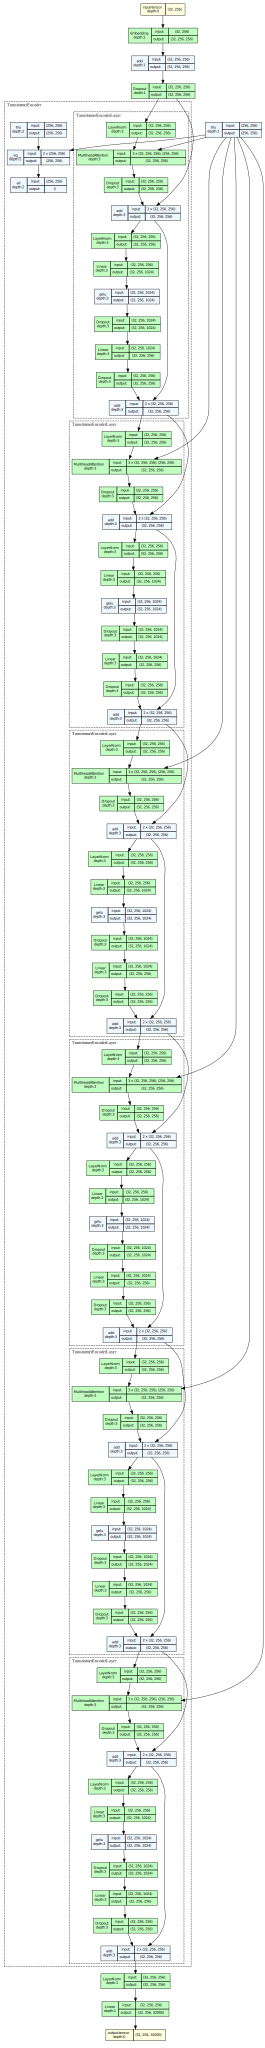

In [16]:
# Install torchview for compact visualization
try:
    import torchview
except ImportError:
    %pip install torchview
    import torchview

from torchview import draw_graph

# 1. Print Model Statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Structure:\n{model}\n")
print("-" * 50)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# Estimate model size in MB (assuming float32 - 4 bytes per param)
param_size = total_params * 4 / (1024 * 1024)
print(f"Estimated Model Size (Params only): {param_size:.2f} MB")
print("-" * 50)

# 2. Generate Diagram using torchview
print("Generating compact model diagram...")

# Create dummy input with correct type (Long) for the embedding layer
dummy_input = torch.randint(0, tokenizer_vocab, (BATCH_SIZE, BLOCK_SIZE), dtype=torch.long).to(device)

# draw_graph creates a high-level graph of modules
# depth=3 is usually good for Transformers to see layers but not internal ops
model_graph = draw_graph(
    model, 
    input_data=dummy_input, # Pass actual data to ensure correct type
    device=device,
    expand_nested=True,
    depth=3,
    save_graph=False
)

model_graph.visual_graph

Setup training helpers

In [17]:
# learning rate scheduler setup

def build_scheduler(
    optimizer: torch.optim.Optimizer,
    scheduler_name: str,
    total_steps: int,
    warmup_ratio: float,
) -> Optional[LRScheduler]:
    if scheduler_name == "none" or total_steps <= 0:
        return None

    if not 0.0 <= warmup_ratio <= 1.0:
        raise ValueError("warmup_ratio must be between 0 and 1")

    warmup_steps = int(total_steps * warmup_ratio)
    warmup_steps = max(0, min(warmup_steps, total_steps))

    if scheduler_name == "linear":
        return get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )
    if scheduler_name == "cosine":
        return get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )

    raise ValueError(f"Unsupported lr scheduler: {scheduler_name}")

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler(device="cuda", enabled=True)

total_train_steps = len(train_loader) * EPOCHS

# Warmup + decay scheduling is a robust default for compact language models.
scheduler = build_scheduler(
    optimizer=optimizer,
    scheduler_name=LR_SCHEDULER,
    total_steps=total_train_steps,
    warmup_ratio=WARMUP_RATIO,
)


Training helper

In [19]:
def train_one_epoch(
    model: MiniTransformerLanguageModel,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    scaler: Optional[torch.cuda.amp.GradScaler],
    grad_clip: float,
    scheduler: Optional[LRScheduler],
    log_interval: Optional[int] = None,
) -> Tuple[float, float]:
    model.train()
    total_loss = 0.0
    total_tokens = 0
    for step, (inputs, targets) in enumerate(loader, start=1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=scaler is not None):
            logits = model(inputs)
            loss = criterion(logits.view(-1, model.vocab_size), targets.reshape(-1))
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        loss_value = loss.detach().float().item()
        step_tokens = targets.numel()
        total_loss += loss_value * step_tokens
        total_tokens += step_tokens

        if log_interval and step % log_interval == 0:
            running_avg = total_loss / max(total_tokens, 1)
            running_ppl = math.exp(min(running_avg, 20.0))
            current_lr = optimizer.param_groups[0]["lr"]
            print(
                f"  Step {step}/{len(loader)} - Loss: {running_avg:.4f} | PPL: {running_ppl:.2f} | LR: {current_lr:.6e}"
            )

    avg_loss = total_loss / max(total_tokens, 1)
    perplexity = math.exp(min(avg_loss, 20.0))
    return avg_loss, perplexity

Perplexity based evaluation function

In [20]:
@torch.no_grad()
def evaluate(
    model: MiniTransformerLanguageModel,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        loss = criterion(logits.view(-1, model.vocab_size), targets.reshape(-1))
        loss_value = loss.detach().float().item()
        total_loss += loss_value * targets.numel()
        total_tokens += targets.numel()
    if total_tokens == 0:
        return float("inf"), float("inf")
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(min(avg_loss, 20.0))
    return avg_loss, perplexity

In [21]:
history: List[dict] = []
best_train_perplexity = float("inf")
for epoch in range(1, EPOCHS + 1):
    train_loss, train_ppl = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        scaler,
        GRADIENT_CLIPPING,
        scheduler,
        LOG_INTERVAL,
    )
    val_loss, val_ppl = evaluate(model, val_loader, criterion, device)
    history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "train_perplexity": train_ppl,
                "val_loss": val_loss,
                "val_perplexity": val_ppl,
                "learning_rate": optimizer.param_groups[0]["lr"],
            }
        )

    print(
        f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train PPL: {train_ppl:.2f} | "
        f"Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.2f}"
    )

    if train_ppl < best_train_perplexity:
        best_train_perplexity = train_ppl
        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)
        torch.save(model, OUTPUT_DIR + "/best_model.pth")
        print(f"Saved new best model to {OUTPUT_DIR + '/best_model.pth'} with Train PPL: {train_ppl:.2f}")

  Step 100/4407 - Loss: 10.3843 | PPL: 32348.29 | LR: 6.807352e-07
  Step 200/4407 - Loss: 10.3621 | PPL: 31637.92 | LR: 1.361470e-06
  Step 200/4407 - Loss: 10.3621 | PPL: 31637.92 | LR: 1.361470e-06
  Step 300/4407 - Loss: 10.3274 | PPL: 30559.07 | LR: 2.042206e-06
  Step 300/4407 - Loss: 10.3274 | PPL: 30559.07 | LR: 2.042206e-06
  Step 400/4407 - Loss: 10.2870 | PPL: 29349.14 | LR: 2.722941e-06
  Step 400/4407 - Loss: 10.2870 | PPL: 29349.14 | LR: 2.722941e-06
  Step 500/4407 - Loss: 10.2437 | PPL: 28104.69 | LR: 3.403676e-06
  Step 500/4407 - Loss: 10.2437 | PPL: 28104.69 | LR: 3.403676e-06
  Step 600/4407 - Loss: 10.1986 | PPL: 26865.58 | LR: 4.084411e-06
  Step 600/4407 - Loss: 10.1986 | PPL: 26865.58 | LR: 4.084411e-06
  Step 700/4407 - Loss: 10.1512 | PPL: 25620.86 | LR: 4.765146e-06
  Step 700/4407 - Loss: 10.1512 | PPL: 25620.86 | LR: 4.765146e-06
  Step 800/4407 - Loss: 10.1014 | PPL: 24376.58 | LR: 5.445882e-06
  Step 800/4407 - Loss: 10.1014 | PPL: 24376.58 | LR: 5.445882

In [ ]:
# Plot LM training curves
try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt

def plot_lm_training_curves(history):
    """Plot training loss and perplexity curves for the language model."""
    if not history:
        print("No training history to plot.")
        return
    
    epochs = [h["epoch"] for h in history]
    train_loss = [h["train_loss"] for h in history]
    val_loss = [h["val_loss"] for h in history]
    train_ppl = [h["train_perplexity"] for h in history]
    val_ppl = [h["val_perplexity"] for h in history]
    lr = [h["learning_rate"] for h in history]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot Training and Validation Loss
    ax1 = axes[0, 0]
    ax1.plot(epochs, train_loss, label="Train Loss", color='blue', marker='o', markersize=3)
    ax1.plot(epochs, val_loss, label="Val Loss", color='orange', marker='s', markersize=3)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Training and Validation Perplexity
    ax2 = axes[0, 1]
    ax2.plot(epochs, train_ppl, label="Train Perplexity", color='blue', marker='o', markersize=3)
    ax2.plot(epochs, val_ppl, label="Val Perplexity", color='orange', marker='s', markersize=3)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Perplexity")
    ax2.set_title("Training and Validation Perplexity")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot Perplexity (log scale for better visualization)
    ax3 = axes[1, 0]
    ax3.semilogy(epochs, train_ppl, label="Train Perplexity", color='blue', marker='o', markersize=3)
    ax3.semilogy(epochs, val_ppl, label="Val Perplexity", color='orange', marker='s', markersize=3)
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Perplexity (log scale)")
    ax3.set_title("Perplexity (Log Scale)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot Learning Rate Schedule
    ax4 = axes[1, 1]
    ax4.plot(epochs, lr, label="Learning Rate", color='green', marker='^', markersize=3)
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Learning Rate")
    ax4.set_title("Learning Rate Schedule")
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("Training Summary:")
    print(f"  Final Train Loss: {train_loss[-1]:.4f} | Final Train PPL: {train_ppl[-1]:.2f}")
    print(f"  Final Val Loss: {val_loss[-1]:.4f} | Final Val PPL: {val_ppl[-1]:.2f}")
    print(f"  Best Train PPL: {min(train_ppl):.2f} (Epoch {train_ppl.index(min(train_ppl)) + 1})")
    print(f"  Best Val PPL: {min(val_ppl):.2f} (Epoch {val_ppl.index(min(val_ppl)) + 1})")
    print("="*50)

plot_lm_training_curves(history)

Sanity check and try out the model

In [22]:
# load best model
if os.path.exists(f"{OUTPUT_DIR}/best_model.pth"):
    model = torch.load(f"{OUTPUT_DIR}/best_model.pth", map_location=device)
    model.eval()
    print(f"Loaded best model from {OUTPUT_DIR}/best_model.pth")
else:
    print(f"Model file not found at {OUTPUT_DIR}/best_model.pth. Please ensure training has completed.")

/tmp/ipykernel_17172/2424659314.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"{OUTPUT_DIR}/best_model.pth", map_location=device)


Loaded best model from models/tagalog_lm/best_model.pth


In [23]:
import ipywidgets as widgets
from IPython.display import display

def generate_text(prompt, max_new_tokens, temperature, top_k):
    model.eval()
    # Encode prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    # If prompt is empty or just whitespace, handle gracefully
    if input_ids.numel() == 0:
        print("Please enter a valid prompt.")
        return ""

    try:
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=top_k
        )
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return generated_text
    except Exception as e:
        return f"Error during generation: {str(e)}"

# UI Components
prompt_widget = widgets.Textarea(
    value='Ang',
    placeholder='Type your Tagalog prompt here...',
    description='Prompt:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='100px')
)

max_tokens_widget = widgets.IntSlider(
    value=50,
    min=10,
    max=500,
    step=10,
    description='Max Tokens:',
    style={'description_width': 'initial'},
    continuous_update=False
)

temperature_widget = widgets.FloatSlider(
    value=0.8,
    min=0.1,
    max=2.0,
    step=0.1,
    description='Temperature:',
    style={'description_width': 'initial'},
    continuous_update=False
)

top_k_widget = widgets.IntSlider(
    value=40,
    min=0,
    max=100,
    step=5,
    description='Top K (0=off):',
    style={'description_width': 'initial'},
    continuous_update=False
)

generate_button = widgets.Button(
    description="Generate Text",
    button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
    icon='magic'
)

output_area = widgets.Output(layout={'border': '1px solid #ccc', 'padding': '10px'})

def on_generate_click(b):
    with output_area:
        output_area.clear_output()
        print("Generating response...")
        
        result = generate_text(
            prompt_widget.value,
            max_tokens_widget.value,
            temperature_widget.value,
            top_k_widget.value
        )
        
        output_area.clear_output()
        print("--- Generated Output ---")
        print(result)

generate_button.on_click(on_generate_click)

# Layout
controls = widgets.VBox([
    max_tokens_widget,
    temperature_widget,
    top_k_widget
])

ui = widgets.VBox([
    widgets.HTML("<h3>Interactive Model Tester</h3>"),
    prompt_widget,
    controls,
    generate_button,
    output_area
])

display(ui)

Let's now train a classifier with the LM as the backbone

In [24]:
@dataclass
class TagalogLMClassifierConfig:
    num_labels: int = 2
    hidden_dim: Optional[int] = None
    classifier_dropout: float = 0.2
    pooling: str = "mean"  # options: mean, last
    fine_tune_base: bool = False

class TagalogLMClassifier(nn.Module):
    """Sequence classifier that reuses a pretrained Tagalog LM backbone."""

    def __init__(
        self,
        language_model: MiniTransformerLanguageModel,
        config: TagalogLMClassifierConfig,
    ) -> None:
        super().__init__()
        self.language_model = language_model
        self.config = config
        self.num_labels = config.num_labels
        embed_dim = language_model.embed_dim
        hidden_dim = config.hidden_dim or embed_dim

        self.pre_classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(config.classifier_dropout),
        )
        self.output_layer = nn.Linear(hidden_dim, self.num_labels)

        if not config.fine_tune_base:
            self.freeze_backbone()
        else:
            self.language_model.train()

    def freeze_backbone(self) -> None:
        for param in self.language_model.parameters():
            param.requires_grad = False
        self.language_model.eval()

    def unfreeze_backbone(self) -> None:
        for param in self.language_model.parameters():
            param.requires_grad = True
        self.language_model.train()

    def train(self, mode: bool = True) -> "TagalogLMClassifier":  # type: ignore[override]
        super().train(mode)
        if not self.config.fine_tune_base:
            self.language_model.eval()
        return self

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        if not self.config.fine_tune_base:
            with torch.no_grad():
                hidden_states = self.language_model.encode(input_ids)
        else:
            hidden_states = self.language_model.encode(input_ids)

        if attention_mask is not None:
            mask = attention_mask.to(hidden_states.dtype).unsqueeze(-1)
            masked_hidden = hidden_states * mask
            denom = mask.sum(dim=1).clamp_min(1.0)
            pooled = masked_hidden.sum(dim=1) / denom
        elif self.config.pooling == "last":
            pooled = hidden_states[:, -1, :]
        else:
            pooled = hidden_states.mean(dim=1)

        features = self.pre_classifier(pooled)
        logits = self.output_layer(features)
        return logits

    def get_classifier_config(self) -> Dict[str, object]:
        return {
            "num_labels": self.num_labels,
            "hidden_dim": self.config.hidden_dim,
            "classifier_dropout": self.config.classifier_dropout,
            "pooling": self.config.pooling,
            "fine_tune_base": self.config.fine_tune_base,
        }

    @staticmethod
    def _build_language_model_from_config(lm_config: Dict[str, object]) -> MiniTransformerLanguageModel:
        return MiniTransformerLanguageModel(
            vocab_size=int(lm_config["vocab_size"]),
            embed_dim=int(lm_config.get("embed_dim", 256)),
            num_heads=int(lm_config.get("num_heads", 4)),
            num_layers=int(lm_config.get("num_layers", 4)),
            max_position_embeddings=int(lm_config.get("max_position_embeddings", 512)),
            dropout=float(lm_config.get("dropout", 0.1)),
            ff_multiplier=int(lm_config.get("ff_multiplier", 4)),
        )

    @classmethod
    def from_configs(
        cls,
        lm_config: Dict[str, object],
        classifier_config: Dict[str, object],
        device: Optional[torch.device] = None,
    ) -> "TagalogLMClassifier":
        lm = cls._build_language_model_from_config(lm_config)
        config = TagalogLMClassifierConfig(
            num_labels=int(classifier_config.get("num_labels", 2)),
            hidden_dim=classifier_config.get("hidden_dim"),
            classifier_dropout=float(classifier_config.get("classifier_dropout", 0.2)),
            pooling=classifier_config.get("pooling", "mean"),
            fine_tune_base=bool(classifier_config.get("fine_tune_base", False)),
        )
        model = cls(lm, config)
        if device is not None:
            model.to(device)
        return model

    def load_backbone_weights(self, state_dict: Dict[str, torch.Tensor]) -> None:
        missing, unexpected = self.language_model.load_state_dict(state_dict, strict=False)
        if missing or unexpected:
            raise RuntimeError(
                f"Failed to load language-model weights. Missing: {missing}, unexpected: {unexpected}"
            )

Prepare hatespeech dataset

In [25]:
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
from torch.optim import AdamW
import numpy as np
from tqdm.auto import tqdm

Classifier hyperparameters

In [40]:
CLASSIFICATION_BATCH_SIZE = 32
FINE_TUNE_BASE = True
CLASSIFIER_DROPOUT = 0.2
CLASSIFIER_LEARNING_RATE = 1e-4
CLASSIFIER_GRADIENT_CLIPPING = 1.0
POOLING_STRATEGY = "mean"  # options: mean, last
CLASSIFIER_EPOCHS = 250
CLASSIFIER_WEIGHT_DECAY = 1e-2
CLASSIFICATION_MAX_LENGTH = 256

In [41]:
train_csv = Path("data/combined/processed/train.csv")
val_csv = Path("data/combined/processed/validation.csv")
test_csv = Path("data/combined/processed/test.csv")

text_column = "text"
label_column = "label"

In [42]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts: Sequence[str], labels: Sequence[int]):
        self.texts = list(texts)
        self.labels = [int(label) for label in labels]

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[str, int]:
        return self.texts[idx], self.labels[idx]

In [43]:
def load_dataframe(path: Path, text_column: str, label_column: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if text_column not in df.columns or label_column not in df.columns:
        raise ValueError(f"File {path} must contain '{text_column}' and '{label_column}' columns.")
    return df[[text_column, label_column]].rename(columns={text_column: "text", label_column: "label"})

train_df = load_dataframe(train_csv, text_column, label_column)
val_df = load_dataframe(val_csv, text_column, label_column)
test_df = load_dataframe(test_csv, text_column, label_column)

train_dataset = TextClassificationDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = TextClassificationDataset(val_df["text"].tolist(), val_df["label"].tolist())
test_dataset = TextClassificationDataset(test_df["text"].tolist(), test_df["label"].tolist())

collate_fn = lambda batch: collate_batch(tokenizer, CLASSIFICATION_MAX_LENGTH, batch)
train_loader = DataLoader(train_dataset, batch_size=CLASSIFICATION_BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=CLASSIFICATION_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=CLASSIFICATION_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [44]:
num_labels = len(sorted(set(train_df["label"].astype(int).tolist())))
print(f"Number of labels: {num_labels}")

Number of labels: 2


In [45]:
classifier_config = TagalogLMClassifierConfig(
    num_labels=2,
    classifier_dropout=CLASSIFIER_DROPOUT,
    pooling=POOLING_STRATEGY,
    fine_tune_base=FINE_TUNE_BASE,
)
classifier_model = TagalogLMClassifier(model, classifier_config).to(device)

Generating classifier model diagram...


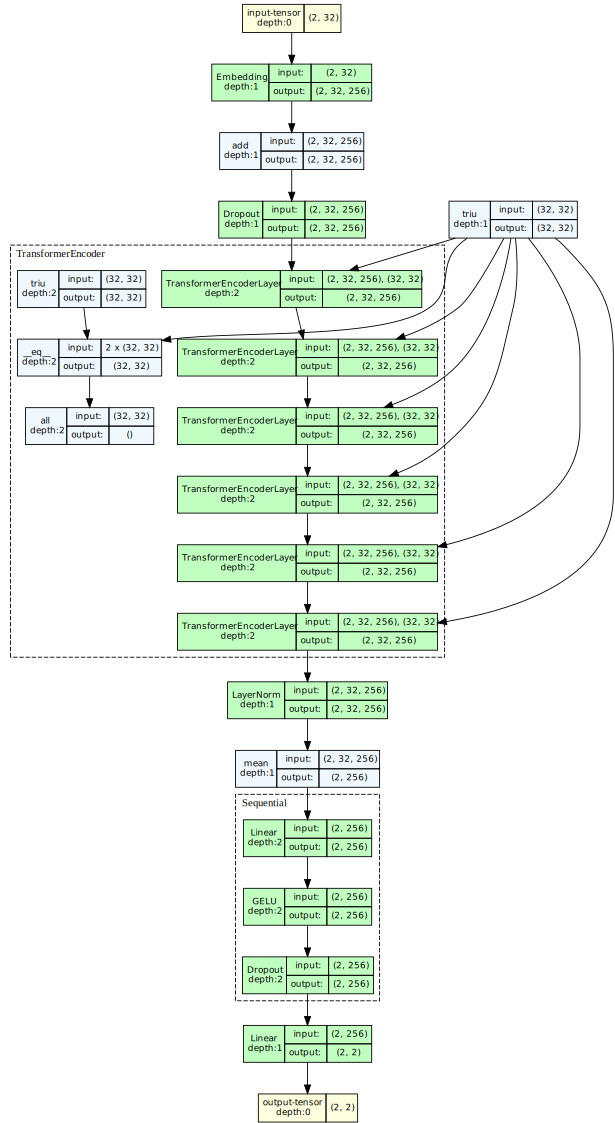

In [46]:
# Generate simple diagram for the classifier model
print("Generating classifier model diagram...")

# Create dummy input
# Using a small batch size for the diagram
dummy_batch_size = 2
dummy_seq_len = 32
dummy_input_ids = torch.randint(0, tokenizer_vocab, (dummy_batch_size, dummy_seq_len), dtype=torch.long).to(device)

classifier_graph = draw_graph(
    classifier_model,
    input_data=dummy_input_ids,
    device=device,
    expand_nested=True,
    depth=2, # Keep depth low for simplicity
    save_graph=False
)

classifier_graph.visual_graph

In [47]:
# Model Architecture Summary using torchinfo
try:
    from torchinfo import summary
except ImportError:
    !pip install torchinfo
    from torchinfo import summary

# Summary for the full classifier model
print("=" * 70)
print(" TagalogLMClassifier - Full Model Summary")
print("=" * 70)
summary(
    classifier_model,
    input_size=(CLASSIFICATION_BATCH_SIZE, CLASSIFICATION_MAX_LENGTH),
    dtypes=[torch.long],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=18,
    row_settings=["var_names"],
    depth=4,
)

# Summary for just the language model backbone
print("\n" + "=" * 70)
print(" Language Model Backbone Summary")
print("=" * 70)
summary(
    classifier_model.language_model,
    input_size=(CLASSIFICATION_BATCH_SIZE, CLASSIFICATION_MAX_LENGTH),
    dtypes=[torch.long],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=18,
    row_settings=["var_names"],
    depth=4,
)

 TagalogLMClassifier - Full Model Summary

 Language Model Backbone Summary


Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
MiniTransformerLanguageModel (MiniTransformerLanguageModel)  [32, 256]          [32, 256, 32000]   131,072            False
├─Embedding (token_embedding)                                [32, 256]          [32, 256, 256]     (8,192,000)        False
├─Dropout (dropout)                                          [32, 256, 256]     [32, 256, 256]     --                 --
├─TransformerEncoder (transformer)                           [32, 256, 256]     [32, 256, 256]     --                 False
│    └─ModuleList (layers)                                   --                 --                 --                 False
│    │    └─TransformerEncoderLayer (0)                      [32, 256, 256]     [32, 256, 256]     --                 False
│    │    │    └─LayerNorm (norm1)                           [32, 256, 256]     [32, 256, 256]     (512)              False
│    │ 

Training of the classifier + LM backbone

In [48]:
from tqdm.notebook import tqdm
from IPython.display import clear_output, display

def collate_batch(tokenizer, max_length: int, batch: List[Tuple[str, int]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    texts, labels = zip(*batch)
    encoding = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return encoding["input_ids"], encoding["attention_mask"], label_tensor

def compute_metrics(logits: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)

    tp = ((preds == 1) & (labels == 1)).sum().item()
    fp = ((preds == 1) & (labels == 0)).sum().item()
    fn = ((preds == 0) & (labels == 1)).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        "accuracy": correct / total if total > 0 else 0.0,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def aggregate_metrics(metric_list: List[Dict[str, float]]) -> Dict[str, float]:
    if not metric_list:
        return {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}
    keys = metric_list[0].keys()
    results = {}
    for key in keys:
        values = [metrics[key] for metrics in metric_list]
        results[key] = float(np.mean(values))
        results[f"{key}_std"] = float(np.std(values))
    return results

@torch.no_grad()
def evaluate(
    model: TagalogLMClassifier,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, Dict[str, float]]:
    model.eval()
    total_loss = 0.0
    metrics_accumulator: List[Dict[str, float]] = []

    for input_ids, attention_mask, targets in loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, targets)

        total_loss += loss.item()
        metrics_accumulator.append(compute_metrics(logits.cpu(), targets.cpu()))

    avg_loss = total_loss / max(len(loader), 1)
    avg_metrics = aggregate_metrics(metrics_accumulator)
    return avg_loss, avg_metrics

def train_classifier_one_epoch(
    model: TagalogLMClassifier,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: Optional[GradScaler],
    device: torch.device,
    grad_clip: float,
    use_autocast: bool,
) -> Tuple[float, Dict[str, float]]:
    model.train()
    total_loss = 0.0
    metrics_accumulator: List[Dict[str, float]] = []

    for input_ids, attention_mask, targets in loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=use_autocast):
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, targets)

        if scaler is not None and use_autocast:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val
        metrics_accumulator.append(compute_metrics(logits.detach().cpu(), targets.detach().cpu()))

    avg_loss = total_loss / max(len(loader), 1)
    avg_metrics = aggregate_metrics(metrics_accumulator)
    return avg_loss, avg_metrics

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW([p for p in classifier_model.parameters() if p.requires_grad], lr=CLASSIFIER_LEARNING_RATE, weight_decay=CLASSIFIER_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, CLASSIFIER_EPOCHS))
scaler = GradScaler(enabled=True)

/tmp/ipykernel_17172/2128070876.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)


In [49]:
import copy
import numpy as np

SEEDS = [42, 43, 44, 45, 46]
PATIENCE_LIMIT = 10
all_run_metrics = []

print(f"Starting multi-seed training with seeds: {SEEDS}")

# We'll keep the history of the last run for visualization purposes
history: List[Dict[str, Dict[str, float]]] = []

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'='*20} Run with Seed {seed} ({seed_idx+1}/{len(SEEDS)}) {'='*20}")
    
    # Set seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
    # Re-initialize model
    # Deepcopy backbone to ensure fresh start for each seed
    current_backbone = copy.deepcopy(model)
    
    classifier_config = TagalogLMClassifierConfig(
        num_labels=num_labels, 
        classifier_dropout=CLASSIFIER_DROPOUT,
        pooling=POOLING_STRATEGY,
        fine_tune_base=FINE_TUNE_BASE,
    )
    classifier_model = TagalogLMClassifier(current_backbone, classifier_config).to(device)
    
    # Re-initialize Optimizer and Scheduler
    optimizer = AdamW([p for p in classifier_model.parameters() if p.requires_grad], lr=CLASSIFIER_LEARNING_RATE, weight_decay=CLASSIFIER_WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, CLASSIFIER_EPOCHS))
    scaler = GradScaler(enabled=True)
    
    # Training Loop
    best_val_f1 = 0.0
    best_metrics_for_seed = {}
    patience_counter = 0
    model_path = f"{OUTPUT_DIR}/tagalog_classifier_seed_{seed}.pt"
    
    # Reset history for this seed
    history = []
    
    # Use tqdm.notebook for proper Jupyter display
    epoch_pbar = tqdm(range(1, CLASSIFIER_EPOCHS + 1), desc=f"Seed {seed}", leave=True)
    
    for epoch in epoch_pbar:
        train_loss, train_metrics = train_classifier_one_epoch(
            classifier_model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            device,
            CLASSIFIER_GRADIENT_CLIPPING,
            True,
        )
        val_loss, val_metrics = evaluate(classifier_model, val_loader, criterion, device)
        scheduler.step()
        
        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "train_metrics": train_metrics,
                "val_loss": val_loss,
                "val_metrics": val_metrics,
                "learning_rate": optimizer.param_groups[0]["lr"],
            }
        )

        # Update progress bar with metrics
        epoch_pbar.set_postfix({
            "train_loss": f"{train_loss:.4f}",
            "val_f1": f"{val_metrics.get('f1', 0.0):.4f}",
            "best_f1": f"{best_val_f1:.4f}",
            "patience": f"{patience_counter}/{PATIENCE_LIMIT}"
        })

        improved = val_metrics.get("f1", 0.0) > best_val_f1
        if improved:
            best_val_f1 = val_metrics.get("f1", 0.0)
            best_metrics_for_seed = val_metrics
            patience_counter = 0
            torch.save(classifier_model.state_dict(), model_path)
    
    print(f"Seed {seed} Finished | Best F1: {best_val_f1:.4f}")
    if best_metrics_for_seed:
        all_run_metrics.append(best_metrics_for_seed)

# Aggregation and Reporting
print("\n" + "="*50)
print(f"Multi-run Results ({len(SEEDS)} runs):")
metrics_keys = ["accuracy", "precision", "recall", "f1"]

for key in metrics_keys:
    values = [m.get(key, 0.0) for m in all_run_metrics]
    if values:
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{key.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")
    else:
        print(f"{key.capitalize()}: N/A")
print("="*50)

Starting multi-seed training with seeds: [42, 43, 44, 45, 46]

==================== Run with Seed 42 (1/5) ====================


/tmp/ipykernel_17172/153772849.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)


Seed 42:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_17172/516048449.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_autocast):


Seed 42 Finished | Best F1: 0.7794

==================== Run with Seed 43 (2/5) ====================


Seed 43:   0%|          | 0/250 [00:00<?, ?it/s]

Seed 43 Finished | Best F1: 0.7751

==================== Run with Seed 44 (3/5) ====================


Seed 44:   0%|          | 0/250 [00:00<?, ?it/s]

Seed 44 Finished | Best F1: 0.7749

==================== Run with Seed 45 (4/5) ====================


Seed 45:   0%|          | 0/250 [00:00<?, ?it/s]

Seed 45 Finished | Best F1: 0.7711

==================== Run with Seed 46 (5/5) ====================


Seed 46:   0%|          | 0/250 [00:00<?, ?it/s]

Seed 46 Finished | Best F1: 0.7774

Multi-run Results (5 runs):
Accuracy: 0.7959 ± 0.0043
Precision: 0.7765 ± 0.0119
Recall: 0.7864 ± 0.0118
F1: 0.7756 ± 0.0028


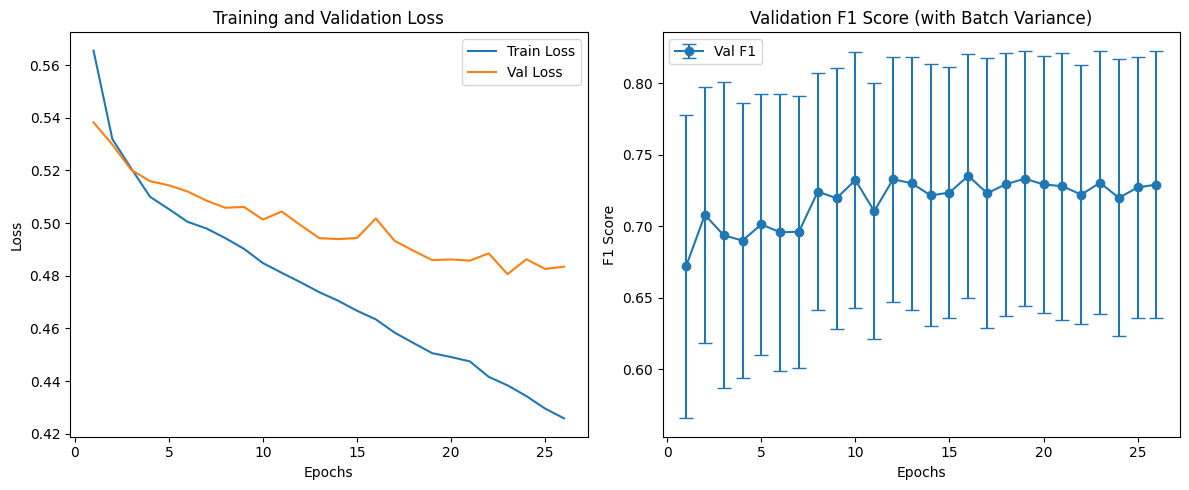

In [36]:
# Plot training history with error bars
try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = [h["epoch"] for h in history]
    train_loss = [h["train_loss"] for h in history]
    val_loss = [h["val_loss"] for h in history]
    
    val_f1 = [h["val_metrics"]["f1"] for h in history]
    val_f1_std = [h["val_metrics"].get("f1_std", 0.0) for h in history]
    
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot F1 with Error Bars
    plt.subplot(1, 2, 2)
    plt.errorbar(epochs, val_f1, yerr=val_f1_std, label="Val F1", fmt='-o', capsize=5)
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("Validation F1 Score (with Batch Variance)")
    
    plt.tight_layout()
    plt.show()

if history:
    plot_training_history(history)